# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
np.random.seed(2344222) # Set seed for numpy. Put your SID instead of number '42'
random.seed(2344222) # Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
tf.random.set_seed(2344222) # Set seed for TensorFlow. Put your SID instead of number '42'
K.clear_session()


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    return model

## 2 clients

In [7]:
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, random_state=2344222)



In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)


(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 2s 1ms/step - loss: 0.3469 - accuracy: 0.9014
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1624 - accuracy: 0.9523
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1130 - accuracy: 0.9669
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0844 - accuracy: 0.9747
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0641 - accuracy: 0.9807
Epoch 1/5
938/938 [==============================] - 2s 1ms/step - loss: 0.3421 - accuracy: 0.9030
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1607 - accuracy: 0.9543
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1093 - accuracy: 0.9682
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0831 - accuracy: 0.9749
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0616 - accuracy: 0.9816


In [10]:
# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [13]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 0.3182 - accuracy: 0.9253 - 422ms/epoch - 1ms/step
Test accuracy: 0.9253000020980835


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [15]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 0s 936us/step
(10000, 10)


In [16]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.96      0.97      1135
           2       0.91      0.97      0.94      1032
           3       0.92      0.91      0.91      1010
           4       0.98      0.86      0.91       982
           5       0.85      0.95      0.90       892
           6       0.97      0.91      0.94       958
           7       0.96      0.90      0.93      1028
           8       0.84      0.90      0.87       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [17]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))


Accuracy test set: 0.9253
precison test set: 0.9280436686653154
Recall test set: 0.9253
f-score test set: 0.9255625700071943


In [18]:
test_precision= []
test_recall = []
test_f1_score = []
test_accuracy=[]

In [19]:
test_accuracy.append(0.9253)
test_precision.append(0.9280436686653154)
test_recall.append(0.9253)
test_f1_score.append(0.9255625700071943)

In [20]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9253]
[0.9280436686653154]
[0.9253]
[0.9255625700071943]


## 4 clients

In [21]:
# split data into 4 clients

In [22]:
client_1 = (x_train[0:15000], y_train[0:15000])
client_2 = (x_train[15000:30000], y_train[15000:30000])
client_3 = (x_train[30000:45000], y_train[30000:45000])
client_4 = (x_train[45000:], y_train[45000:])


In [23]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [24]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])

Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 0.4591 - accuracy: 0.8731
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.2065 - accuracy: 0.9429
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1467 - accuracy: 0.9577
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9697
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0837 - accuracy: 0.9763
Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 2.3149 - accuracy: 0.1016
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 2.2972 - accuracy: 0.1189
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 2.2872 - accuracy: 0.1321
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2734 - accuracy: 0.1413
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 2.2546 - accuracy: 0.1538
Epoch 1/5


In [25]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2,  weights3,  weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights

In [26]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights())

In [27]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 2.2286 - accuracy: 0.3174 - 415ms/epoch - 1ms/step
Test accuracy: 0.3174000084400177


In [28]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 0s 991us/step
(10000, 10)


In [29]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.3174
precison test set: 0.4613970895678904
Recall test set: 0.3174
f-score test set: 0.2677134401243799


In [30]:
test_accuracy.append(0.3174)
test_precision.append(0.4613970895678904)
test_recall.append(0.3174)
test_f1_score.append(0.2677134401243799)

In [31]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9253, 0.3174]
[0.9280436686653154, 0.4613970895678904]
[0.9253, 0.3174]
[0.9255625700071943, 0.2677134401243799]


## 6 clients cell


In [32]:
client_1 = (x_train[0:10000], y_train[0:10000])
client_2 = (x_train[10000:20000], y_train[10000:20000])
client_3 = (x_train[20000:30000], y_train[20000:30000])
client_4 = (x_train[30000:40000], y_train[30000:40000])
client_5 = (x_train[40000:50000], y_train[40000:50000])
client_6 = (x_train[50000:], y_train[50000:])

In [33]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [34]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])
client5_model = train_client_model(client5_model, client_5[0], client_1[1])
client6_model = train_client_model(client6_model, client_6[0], client_1[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5142 - accuracy: 0.8622
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.9338
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1715 - accuracy: 0.9516
Epoch 4/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1308 - accuracy: 0.9625
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1015 - accuracy: 0.9722
Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 2.3211 - accuracy: 0.1035
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2946 - accuracy: 0.1200
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2821 - accuracy: 0.1409
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2623 - accuracy: 0.1530
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2381 - accuracy: 0.1706
Epoch 1/5


In [35]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2,  weights3,  weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights

In [36]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(),client5_model.get_weights(),client6_model.get_weights())

In [37]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 2.2863 - accuracy: 0.2573 - 402ms/epoch - 1ms/step
Test accuracy: 0.2572999894618988


In [38]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 0s 926us/step
(10000, 10)


In [39]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.2573
precison test set: 0.2725372202651795
Recall test set: 0.2573
f-score test set: 0.20799879738149502


In [40]:
test_accuracy.append(0.2573)
test_precision.append(0.2725372202651795)
test_recall.append(0.2573)
test_f1_score.append(0.20799879738149502)

In [41]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9253, 0.3174, 0.2573]
[0.9280436686653154, 0.4613970895678904, 0.2725372202651795]
[0.9253, 0.3174, 0.2573]
[0.9255625700071943, 0.2677134401243799, 0.20799879738149502]


## 8 clients


In [42]:
client_1 = (x_train[0:7500], y_train[0:7500])
client_2 = (x_train[7500:15000], y_train[7500:15000])
client_3 = (x_train[15000:22500], y_train[15000:22500])
client_4 = (x_train[22500:30000], y_train[22500:30000])
client_5 = (x_train[30000:37500], y_train[30000:37500])
client_6 = (x_train[37500:45000], y_train[37500:45000])
client_7 = (x_train[45000:52500], y_train[45000:52500])
client_8 = (x_train[52500:], y_train[52500:]) 

In [43]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [44]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])

Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 0.5725 - accuracy: 0.8427
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.9316
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9495
Epoch 4/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9600
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1123 - accuracy: 0.9691
Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 0.6217 - accuracy: 0.8276
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2876 - accuracy: 0.9224
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2091 - accuracy: 0.9419
Epoch 4/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1601 - accuracy: 0.9575
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1226 - accuracy: 0.9676
Epoch 1/5


In [45]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8) / 8)
    return new_weights

In [46]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights())

In [47]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 1.6181 - accuracy: 0.4458 - 405ms/epoch - 1ms/step
Test accuracy: 0.4458000063896179


In [48]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 0s 953us/step
(10000, 10)


In [49]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.4458
precison test set: 0.7781059567805881
Recall test set: 0.4458
f-score test set: 0.4330983600917826


D:\Softwares\Coding\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
test_accuracy.append(0.4458)
test_precision.append(0.7781059567805881)
test_recall.append(0.4458)
test_f1_score.append(0.4330983600917826)

In [51]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9253, 0.3174, 0.2573, 0.4458]
[0.9280436686653154, 0.4613970895678904, 0.2725372202651795, 0.7781059567805881]
[0.9253, 0.3174, 0.2573, 0.4458]
[0.9255625700071943, 0.2677134401243799, 0.20799879738149502, 0.4330983600917826]


## 10 clients

In [52]:
client_1 = (x_train[0:6000],y_train[0:6000])
client_2= (x_train[6000:12000],y_train[6000:12000])
client_3= (x_train[12000:18000],y_train[12000:18000])
client_4= (x_train[18000:24000], y_train[18000:24000])
client_5=(x_train[24000:30000], y_train[24000:30000])
client_6= (x_train[30000:36000], y_train[30000:36000])
client_7=(x_train[36000:42000], y_train[36000:42000])
client_8=(x_train[42000:48000], y_train[42000:48000])
client_9=(x_train[48000:54000], y_train[48000:54000])
client_10=(x_train[54000:],y_train[54000:])

In [53]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)
print(client_9[0].shape)
print(client_10[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)
print(client_9[1].shape)
print(client_10[1].shape)

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)


In [54]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])
client9_model = train_client_model(client8_model, client_9[0], client_9[1])
client10_model = train_client_model(client8_model, client_10[0], client_10[1])

Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6429 - accuracy: 0.8255
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.9237
Epoch 3/5
188/188 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.9418
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9560
Epoch 5/5
188/188 [==============================] - 0s 1ms/step - loss: 0.1295 - accuracy: 0.9670
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6590 - accuracy: 0.8198
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.9250
Epoch 3/5
188/188 [==============================] - 0s 1ms/step - loss: 0.2142 - accuracy: 0.9405
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9542
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1367 - accuracy: 0.9620
Epoch 1/5


In [55]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights

In [56]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights(),
                                               client9_model.get_weights(), client10_model.get_weights())
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [57]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 - 0s - loss: 1.1103 - accuracy: 0.8090 - 412ms/epoch - 1ms/step
Test accuracy: 0.8090000152587891
313/313 [==============================] - 0s 988us/step
(10000, 10)


In [58]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

print(classification_report(y_test, prediction))

Accuracy test set: 0.809
precison test set: 0.8751506264060693
Recall test set: 0.809
f-score test set: 0.808654347585142
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       980
           1       0.98      0.96      0.97      1135
           2       0.85      0.89      0.87      1032
           3       0.80      0.92      0.86      1010
           4       0.83      0.98      0.90       982
           5       0.44      0.96      0.60       892
           6       0.98      0.73      0.83       958
           7       0.85      0.95      0.90      1028
           8       1.00      0.36      0.53       974
           9       0.98      0.73      0.84      1009

    accuracy                           0.81     10000
   macro avg       0.87      0.81      0.80     10000
weighted avg       0.88      0.81      0.81     10000



In [59]:
test_accuracy.append(0.809)
test_precision.append(0.8751506264060693)
test_recall.append(0.809)
test_f1_score.append(0.808654347585142)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9253, 0.3174, 0.2573, 0.4458, 0.809]
[0.9280436686653154, 0.4613970895678904, 0.2725372202651795, 0.7781059567805881, 0.8751506264060693]
[0.9253, 0.3174, 0.2573, 0.4458, 0.809]
[0.9255625700071943, 0.2677134401243799, 0.20799879738149502, 0.4330983600917826, 0.808654347585142]


Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.¶

In [60]:
import pandas as pd

In [61]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.9253, 0.3174, 0.2573, 0.4458, 0.809], [0.9280436686653154, 0.4613970895678904, 0.2725372202651795, 0.7781059567805881, 0.8751506264060693], [0.9253, 0.3174, 0.2573, 0.4458, 0.809], [0.9255625700071943, 0.2677134401243799, 0.20799879738149502, 0.4330983600917826, 0.808654347585142]]


,Accuracy,Precision,Recall,F1_Score
2,0.9253,0.928044,0.9253,0.925563
4,0.3174,0.461397,0.3174,0.267713
6,0.2573,0.272537,0.2573,0.207999
8,0.4458,0.778106,0.4458,0.433098
10,0.8090,0.875151,0.8090,0.808654


<Axes: >

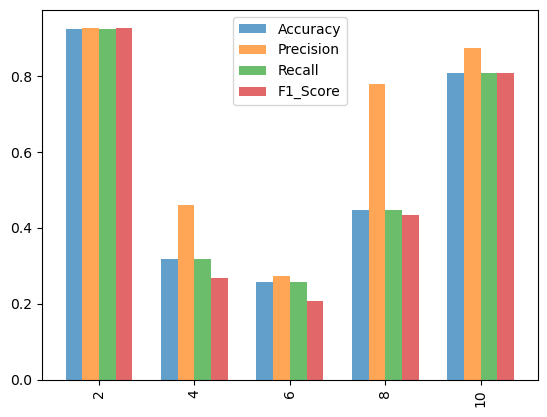

In [62]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

## Dishonest 

In [63]:
# Split data into 8 clients
client_1 = (x_train[0:7500], y_train[0:7500])
client_2 = (x_train[7500:15000], y_train[7500:15000])
client_3 = (x_train[15000:22500], y_train[15000:22500])
client_4 = (x_train[22500:30000], y_train[22500:30000])
client_5 = (x_train[30000:37500], y_train[30000:37500])
client_6 = (x_train[37500:45000], y_train[37500:45000])
client_7 = (x_train[45000:52500], y_train[45000:52500])
client_8 = (x_train[52500:], y_train[52500:]) 

In [64]:
client_7[1].size

7500

In [65]:
client_7[1]

array([3, 1, 1, ..., 7, 1, 4], dtype=uint8)

In [66]:
client_7[1][:7000] = 7

In [67]:
client_7[1]

array([7, 7, 7, ..., 7, 1, 4], dtype=uint8)

In [68]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [69]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])
client5_model = train_client_model(client5_model, client_5[0], client_1[1])
client6_model = train_client_model(client6_model, client_6[0], client_1[1])
client7_model = train_client_model(client7_model, client_7[0], client_1[1])
client8_model = train_client_model(client8_model, client_8[0], client_1[1])

Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 0.5662 - accuracy: 0.8451
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2554 - accuracy: 0.9279
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1852 - accuracy: 0.9497
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.9588
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1148 - accuracy: 0.9681
Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 2.3235 - accuracy: 0.1096
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2884 - accuracy: 0.1328
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2681 - accuracy: 0.1464
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2425 - accuracy: 0.1688
Epoch 5/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2065 - accuracy: 0.1932
Epoch 1/5


In [70]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(), 
                                               client6_model.get_weights(), 
                                               client7_model.get_weights(),
                                               client8_model.get_weights())
                                             
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [71]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 2.2961 - accuracy: 0.1445 - 396ms/epoch - 1ms/step
Test accuracy: 0.1445000022649765
313/313 [==============================] - 0s 948us/step
(10000, 10)
Accuracy test set:  0.1445
Precision test set:  0.21356795637384862
Recall test set:  0.1445
F-score test set:  0.12887178120947168
              precision    recall  f1-score   support

           0       0.27      0.11      0.16       980
           1       0.09      0.25      0.13      1135
           2       0.62      0.29      0.39      1032
           3       0.09      0.01      0.01      1010
           4       0.19      0.45      0.27       982
           5       0.66      0.06      0.12       892
           6       0.11      0.04      0.06       958
           7       0.06      0.17      0.09      1028
           8       0.00      0.00      0.00       974
           9       0.08      0.02      0.04      1009

    accuracy                           0.14     10000
   macro avg       0.22      0.14      0.13

In [72]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [73]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.1445)
test_precision_dishonest.append(0.21356795637384862)
test_recall_dishonest.append(0.1445)
test_f1_score_dishonest.append(0.12887178120947168)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.2573, 0.1445]
[0.2725372202651795, 0.21356795637384862]
[0.2573, 0.1445]
[0.20799879738149502, 0.12887178120947168]


In [74]:
### Plot the model's performance for the 4 clients, one of them (number=3) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#7 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.2573, 0.1445], [0.2725372202651795, 0.21356795637384862], [0.2573, 0.1445], [0.20799879738149502, 0.12887178120947168]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.2573,0.272537,0.2573,0.207999
#7 is dishonest,0.1445,0.213568,0.1445,0.128872


<Axes: >

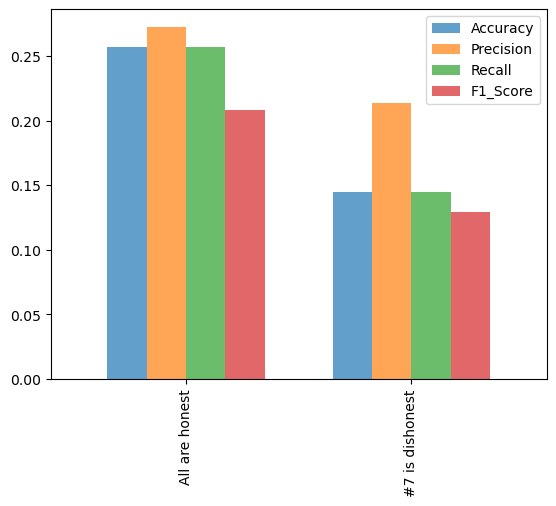

In [75]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.




# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.

